In [10]:
import os
import pandas as pd
import requests
import re

import lancedb
from langdetect import detect

from typing import TypedDict, Annotated, Optional, List

from langchain.vectorstores import LanceDB
from langchain.prompts import ChatPromptTemplate
from langchain_ollama.embeddings import OllamaEmbeddings
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langgraph.types import Command
from langchain_ollama.chat_models import ChatOllama
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END
#from langchain.tools import tool
from langchain_core.tools import tool, InjectedToolCallId

In [3]:
model = os.environ['MODEL_NAME']
embedding_model = os.environ['EMBEDDING_MODEL']
translator_model = os.environ['TRANSLATOR_MODEL_NAME']
mealdb = pd.read_csv('mealdb.csv')

print(model)
print(embedding_model)
mealdb.head()

qwen3:1.7b
nomic-embed-text:latest


,Meals
0,Apam balik
1,Apple & Blackberry Crumble
2,Apple Frangipan Tart
3,Ayam Percik
4,Baingan Bharta


In [4]:
db = lancedb.connect("frog-chef-db")
embedding = OllamaEmbeddings(model=embedding_model)

meal_store = LanceDB(connection=db, embedding=embedding, table_name="meals")


In [5]:
test_emb = embedding.embed_query("Как приготовить уху?")

meal_store.similarity_search_by_vector(test_emb)

[Document(metadata={'id': 'e4960168-443c-46c6-9ff0-96ad600d300d'}, page_content='Chakchouka'),
 Document(metadata={'id': '9494ba2a-2530-473c-824d-eb1cdb3cf494'}, page_content='Fish Soup (Ukha)'),
 Document(metadata={'id': '77fdabb6-cf36-479c-a499-0c280e935f2a'}, page_content='Lamb Pilaf (Plov)'),
 Document(metadata={'id': 'e26b1f39-d6c7-4e96-baa7-6a7b59b15fe2'}, page_content='Cabbage Soup (Shchi)')]

In [6]:
translator_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for translating text from English to Russian. Переводи сообщения с английского на русский, сохраняя смысл текста и его формат. You can only translate human's messages. Do not answer questions, only translate from English to Russian.",
        ),
        ("placeholder",  "{input}"),
    ]
)

system_prompt_en = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a cheerful frog chef who helps users with recipes and ingredients. Answer in a friendly, humorous tone but stay on point. You can help user with different recipes, if they ask you. Only pass meal name to the tools, without any other words.",
        ),
        ("placeholder",  "{input}"),
    ]
)

system_prompt_ru = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Ты весёлый лягушонок-повар. Ты помогаешь пользователю с рецептами и ингредиентами. Отвечай дружелюбно, весело, но по делу. Если пользователь спросит рецепт, то воспользуйся своими tools для поиска подходящего рецепта. При вызове tool передавай только название блюда, без других слов. При вызове tool передавай ему название блюда на английском без других слов.",
        ),
        ("placeholder",  "{input}"),
    ]
)

In [ ]:
class AgentState(TypedDict):
    messages: List[HumanMessage | AIMessage]
    language: str
    image: Optional[str]

In [11]:
@tool
def find_closest_meal(tool_call_id: Annotated[str, InjectedToolCallId], meal_query: str) -> dict:
    """If user asks for a meal recipe, run this tool with meal name in English.
    
        Input:
        tool_call_id - id of tool call,
        Meal Name in English
        
        Returns:
        Meal_Recipe_Information: string
    """
    print("Started find meal tool")
    docs = meal_store.similarity_search(meal_query, k=1)
    
    if docs:
        meal_name = docs[0].page_content
    else:
        return
        
    url = f"https://www.themealdb.com/api/json/v1/1/search.php?s={meal_name}"
    response = requests.get(url)
    data = response.json()
    
    meals = data.get("meals")
    if not meals:
        return "Рецепт не найден"
    
    meal = meals[0]
    
    ingredients_str = ''
    for i in range(1, 21):
        if meal['strIngredient' + str(i)] not in ['', None]:
            ingredients_str += f"{str(i)}. {meal['strIngredient' + str(i)]:<20} {meal['strMeasure' + str(i)]}\n" 
        else:
            pass
    
    '''
    result = f"""
    Meal: {meal['strMeal']}
    Meal Category: {meal['strCategory']}
    Meal Origin: {meal['strArea']}
    
    Meal Ingredients:
{ingredients_str}
    
    Meal Recipe: {meal['strInstructions']}
    """
    '''
    
    result = {
        "name": meal['strMeal'],
        "category": meal['strCategory'],
        "origin country": meal['strArea'],
        "ingredients": ingredients_str,
        "instructions": meal['strInstructions']
    }
    
    print(result)
    return Command(update={
        "image": meal['strMealThumb'],
        # update the message history
        "messages": [
            ToolMessage(
                result,
                tool_call_id=tool_call_id
            )
        ]
    })
 

In [12]:
llm = ChatOllama(
    model=model,
    temperature=0.7
).bind_tools([find_closest_meal])

translator = ChatOllama(model=translator_model, temperature=0)

In [13]:
def remove_thinking_tags(text: str) -> str:
    return re.sub(r"<\/?think.*?>", "", text, flags=re.IGNORECASE)


def translation_router(state: AgentState):
    print("Deciding translation")
    print("Bot's answer is in " + detect(state['messages'][-1].content) + " language")
    print("User's question is in " + state['language'] + " language")
    if state['language'] != detect(state['messages'][-1].content):
        return 'translate'
    else:
        return 'next'

def meal_router(state: AgentState):
    print("Deciding meal recipe")
    print(state)
    last_msg = state["messages"][-1]
    if last_msg.tool_calls and isinstance(last_msg, AIMessage):
        return "tools"
    return "end"

def llm_node(state: AgentState):
    print("Entering LLM Node")
    print(state)
    llm_chain = system_prompt_en | llm if state['language'] == 'en' else system_prompt_ru | llm
    response = llm_chain.invoke({'input':state['messages']})
    #response.content = remove_thinking_tags(response.content)
    response.content = re.sub(r"<think>.*?</think>", "", response.content, flags=re.DOTALL).strip()

    
    if not isinstance(response, AIMessage):
        raise ValueError("LLM must return an AIMessage with optional tool_calls")

    state['messages'] = state['messages'] + [response]
    #print(state['messages'])
    return state

def translate_node(state: AgentState):
    print("Entering Translation Node")
    translation_chain = translator_prompt | translator
    translation = translation_chain.invoke({'input':state['messages']})
    state['messages'] = state['messages'] + [translation]
    print(state['messages'])
    return state

find_meal_node = ToolNode([find_closest_meal], messages_key="messages")

In [14]:
builder = StateGraph(AgentState)

builder.add_node("translation_router", lambda state: state)
builder.add_node("translator", translate_node)
builder.add_node("llm", llm_node)
builder.add_node("find_meal", find_meal_node)


builder.add_edge(START, 'llm')
builder.add_conditional_edges("llm", meal_router, {"tools": "find_meal", "end": 'translation_router'})
builder.add_conditional_edges("translation_router", translation_router, {'translate':'translator', 'next':END})
builder.add_edge("translator", END)
builder.add_edge("find_meal", "llm")

graph = builder.compile()


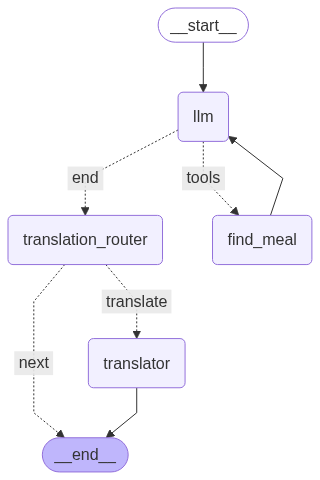

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [16]:
def run_messages(messages: str):
    language = detect(messages) if detect(messages) in ['en', 'ru'] else 'en'
    return graph.invoke({'messages': [HumanMessage(messages)], 'language':language})

In [18]:
run_messages("How to cook blini?")

Entering LLM Node
{'messages': [HumanMessage(content='How to cook blini?', additional_kwargs={}, response_metadata={})], 'language': 'en'}
Deciding meal recipe
{'messages': [HumanMessage(content='How to cook blini?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:1.7b', 'created_at': '2025-06-11T13:16:12.1128387Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4557874700, 'load_duration': 36056300, 'prompt_eval_count': 247, 'prompt_eval_duration': 164829500, 'eval_count': 253, 'eval_duration': 4353424300, 'model_name': 'qwen3:1.7b'}, id='run--98d0a688-2555-4bff-a8e3-9e276b7e9f3f-0', tool_calls=[{'name': 'find_closest_meal', 'args': {'meal_query': 'blini'}, 'id': '5ac52c39-4286-4b8f-9eda-d01f98ea8af0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 247, 'output_tokens': 253, 'total_tokens': 500})], 'language': 'en'}
Started find meal tool
{'name': 'Blini Pancakes', 'category': 'Side', 'origin c

{'messages': [ToolMessage(content="{'name': 'Blini Pancakes', 'category': 'Side', 'origin country': 'Russian', 'ingredients': '1. Buckwheat            1/2 cup \\n2. Flour                2/3 Cup\\n3. Salt                 1/2 tsp\\n4. Yeast                1 tsp \\n5. Milk                 1 cup \\n6. Butter               2 tbs\\n7. Egg                  1 Seperated\\n', 'instructions': 'In a large bowl, whisk together 1/2 cup buckwheat flour, 2/3 cup all-purpose flour, 1/2 teaspoon salt, and 1 teaspoon yeast.\\r\\n\\r\\nMake a well in the center and pour in 1 cup warm milk, whisking until the batter is smooth.\\r\\n\\r\\nCover the bowl and let the batter rise until doubled, about 1 hour.\\r\\n\\r\\nEnrich and Rest the Batter\\r\\nStir 2 tablespoons melted butter and 1 egg yolk into the batter.\\r\\n\\r\\nIn a separate bowl, whisk 1 egg white until stiff, but not dry.\\r\\n\\r\\nFold the whisked egg white into the batter.\\r\\n\\r\\nCover the bowl and let the batter stand 20 minutes.\\r\\n\